## import library and load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

np.random.seed(33)

In [2]:

# Load Train data
X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', sep='\s+', header=None)
y_train = pd.read_csv('UCI HAR Dataset/train/y_train.txt', sep='\s+', header=None, names=['Activity'])

# Load Test data
X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', sep='\s+', header=None)
y_test = pd.read_csv('UCI HAR Dataset/test/y_test.txt', sep='\s+', header=None, names=['Activity'])

# Load feature names
feature_names = pd.read_csv('UCI HAR Dataset/features.txt', sep='\s+', header=None, names=['index', 'feature'])
X_train.columns = feature_names['feature'].values
X_test.columns = feature_names['feature'].values

# Load activity names
activity_labels = pd.read_csv('UCI HAR Dataset/activity_labels.txt', sep='\s+', header=None, names=['code', 'activity'])


print(f"\n X_train Shape: {X_train.shape}")
print(f" y_train Shape: {y_train.shape}")
print(f" X_test Shape: {X_test.shape}")
print(f" y_test Shape: {y_test.shape}")



 X_train Shape: (7352, 561)
 y_train Shape: (7352, 1)
 X_test Shape: (2947, 561)
 y_test Shape: (2947, 1)


In [4]:

print("\n Activity names:")
print(activity_labels)

print("\n Distribution of classes in Train:")
train_dist = y_train['Activity'].value_counts().sort_index()
for idx, count in train_dist.items():
    activity_name = activity_labels[activity_labels['code'] == idx]['activity'].values[0]
    print(f"   Class {idx} ({activity_name}): {count} Sample ({count/len(y_train)*100:.1f}%)")

print("\n Distribution of classes in Test:")
test_dist = y_test['Activity'].value_counts().sort_index()
for idx, count in test_dist.items():
    activity_name = activity_labels[activity_labels['code'] == idx]['activity'].values[0]
    print(f"   Class {idx} ({activity_name}): {count} Sample ({count/len(y_test)*100:.1f}%)")


print(X_train.describe())

print("\n Checking for missing values:")
print(f" Number of NaNs in X_train: {X_train.isna().sum().sum()}")
print(f" Number of NaNs in X_test: {X_test.isna().sum().sum()}")



 Activity names:
   code            activity
0     1             WALKING
1     2    WALKING_UPSTAIRS
2     3  WALKING_DOWNSTAIRS
3     4             SITTING
4     5            STANDING
5     6              LAYING

 Distribution of classes in Train:
   Class 1 (WALKING): 1226 Sample (16.7%)
   Class 2 (WALKING_UPSTAIRS): 1073 Sample (14.6%)
   Class 3 (WALKING_DOWNSTAIRS): 986 Sample (13.4%)
   Class 4 (SITTING): 1286 Sample (17.5%)
   Class 5 (STANDING): 1374 Sample (18.7%)
   Class 6 (LAYING): 1407 Sample (19.1%)

 Distribution of classes in Test:
   Class 1 (WALKING): 496 Sample (16.8%)
   Class 2 (WALKING_UPSTAIRS): 471 Sample (16.0%)
   Class 3 (WALKING_DOWNSTAIRS): 420 Sample (14.3%)
   Class 4 (SITTING): 491 Sample (16.7%)
   Class 5 (STANDING): 532 Sample (18.1%)
   Class 6 (LAYING): 537 Sample (18.2%)
       tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count        7352.000000        7352.000000        7352.000000   
mean            0.274488          -0.017695   

### Visualizing class distribution

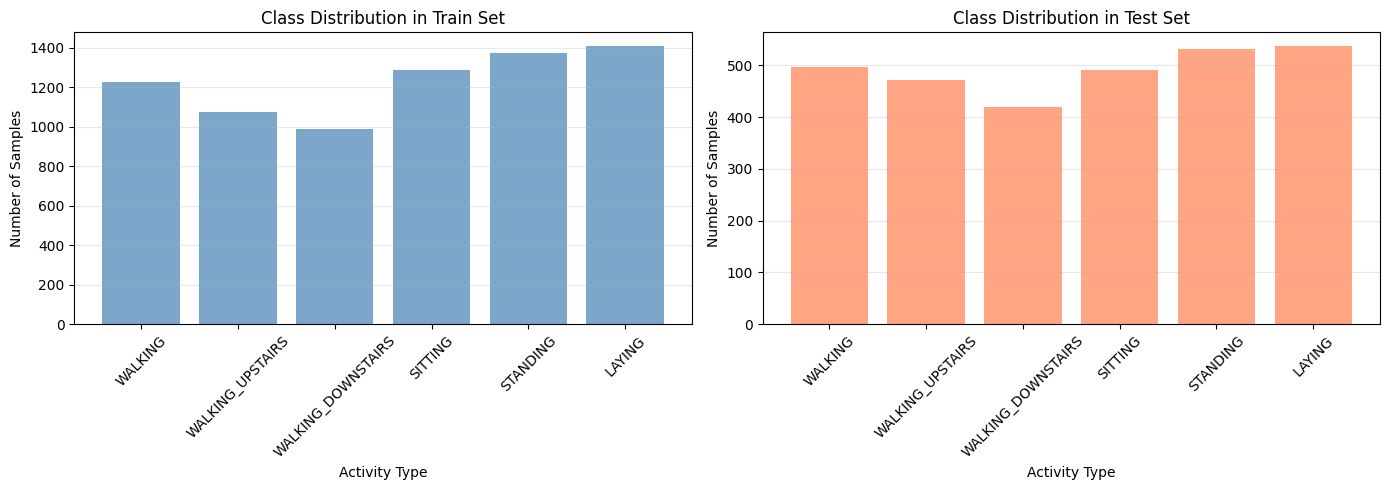

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train
activity_names_train = [activity_labels[activity_labels['code'] == i]['activity'].values[0] for i in train_dist.index]
axes[0].bar(activity_names_train, train_dist.values, color='steelblue', alpha=0.7)
axes[0].set_title('Class Distribution in Train Set')
axes[0].set_xlabel('Activity Type')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Test
activity_names_test = [activity_labels[activity_labels['code'] == i]['activity'].values[0] for i in test_dist.index]
axes[1].bar(activity_names_test, test_dist.values, color='coral', alpha=0.7)
axes[1].set_title('Class Distribution in Test Set')
axes[1].set_xlabel('Activity Type')
axes[1].set_ylabel('Number of Samples')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('class_distribution.pdf', bbox_inches='tight')
plt.show()

## Data preprocessing

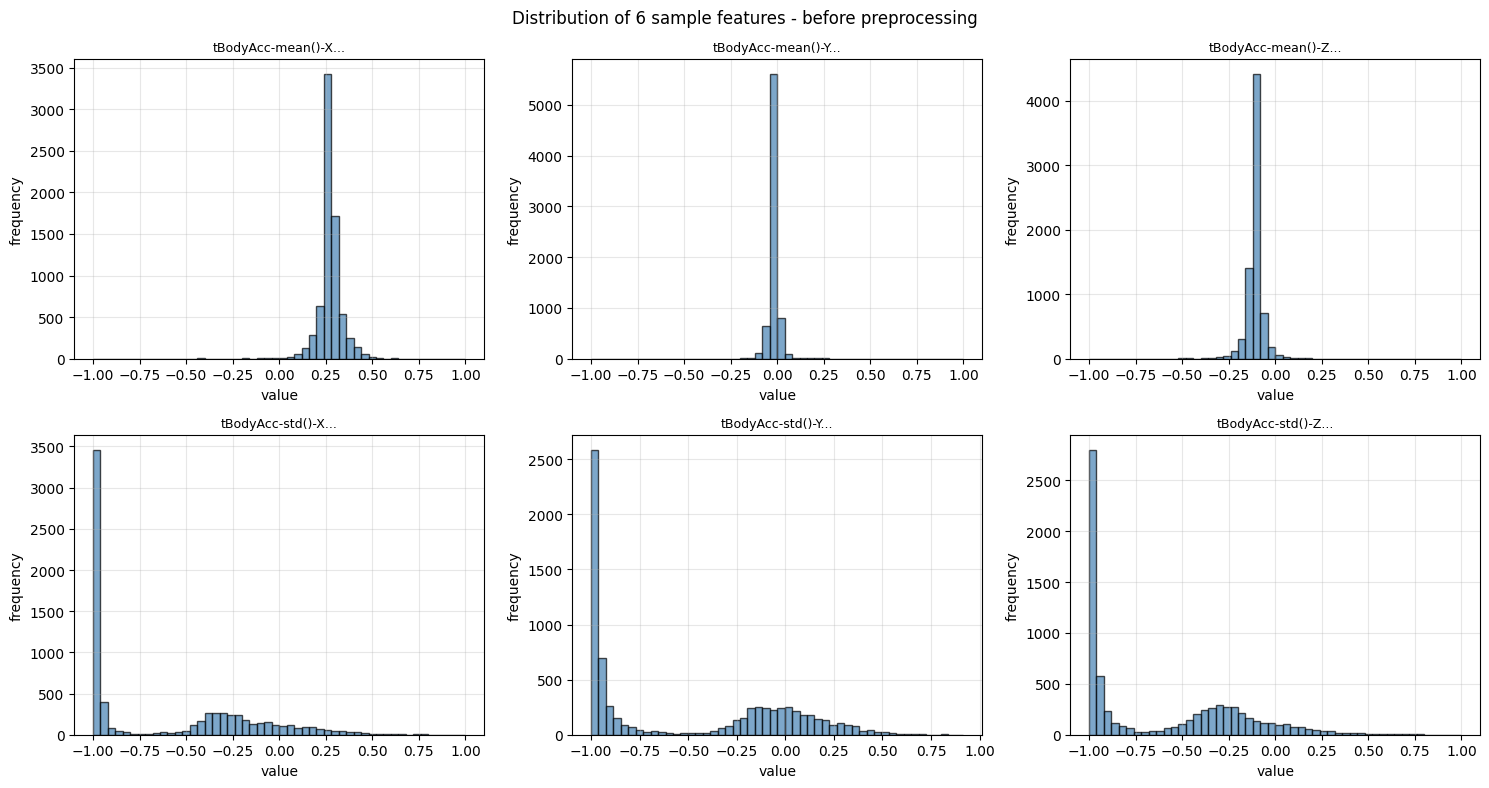

In [8]:
# Show distribution before scaling
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Distribution of 6 sample features - before preprocessing')

sample_features = X_train.columns[:6]
for idx, feature in enumerate(sample_features):
    row, col = idx // 3, idx % 3
    axes[row, col].hist(X_train[feature], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[row, col].set_title(f'{feature[:30]}...', fontsize=9)
    axes[row, col].set_xlabel('value')
    axes[row, col].set_ylabel('frequency')
    axes[row, col].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('distribution_before_scaling.pdf', bbox_inches='tight')
plt.show()


### Check Outliers

In [9]:

Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1

outlier_mask = ((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR)))

outlier_count = outlier_mask.sum().sum()

print(f"Total number of Outliers in Train: {outlier_count}")
print(f" Outliers percentage: {outlier_count / (X_train.shape[0] * X_train.shape[1]) * 100:.2f}%")


Total number of Outliers in Train: 163682
 Outliers percentage: 3.97%


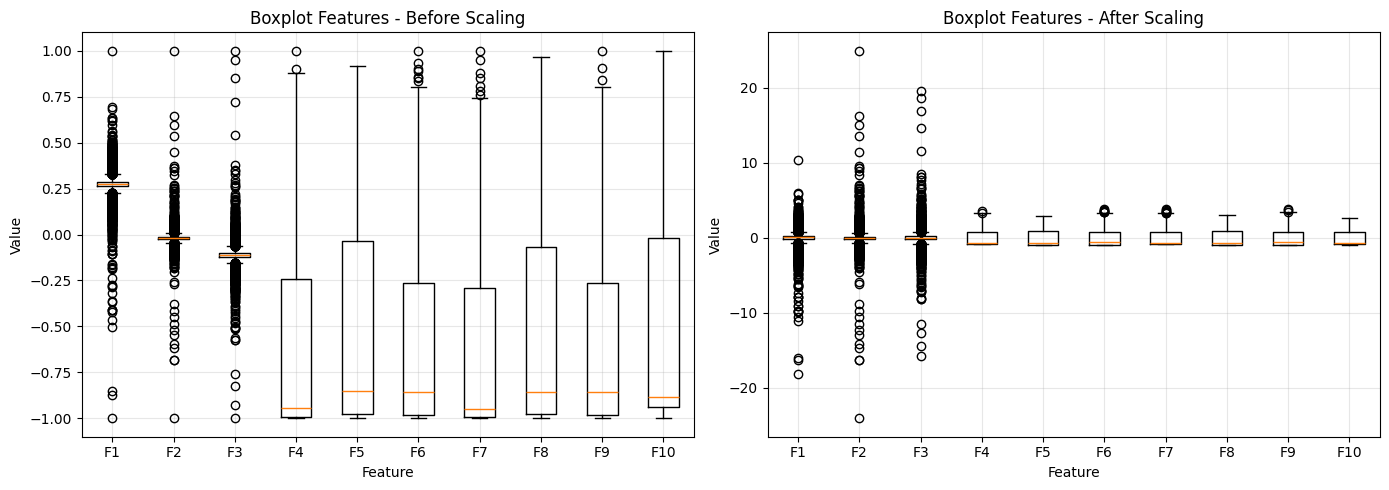

In [11]:
# Boxplot visualization to check for outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Select 10 sample features
sample_features_box = X_train.columns[:10]

axes[0].boxplot([X_train[feat].values for feat in sample_features_box], 
                labels=[f'F{i+1}' for i in range(10)])
axes[0].set_title('Boxplot Features - Before Scaling')
axes[0].set_xlabel('Feature')
axes[0].set_ylabel('Value')
axes[0].grid(alpha=0.3)

# Boxplot after scaling
axes[1].boxplot([X_train_scaled[feat].values for feat in sample_features_box], 
                labels=[f'F{i+1}' for i in range(10)])
axes[1].set_title('Boxplot Features - After Scaling')
axes[1].set_xlabel('Feature')
axes[1].set_ylabel('Value')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('boxplot_comparison.pdf', bbox_inches='tight')
plt.show()

In [10]:
# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print(f" Mean of features after scaling: {X_train_scaled.mean().mean():.6f}")
print(f" Standard deviation of features after scaling: {X_train_scaled.std().mean():.6f}")


 Mean of features after scaling: 0.000000
 Standard deviation of features after scaling: 1.000068


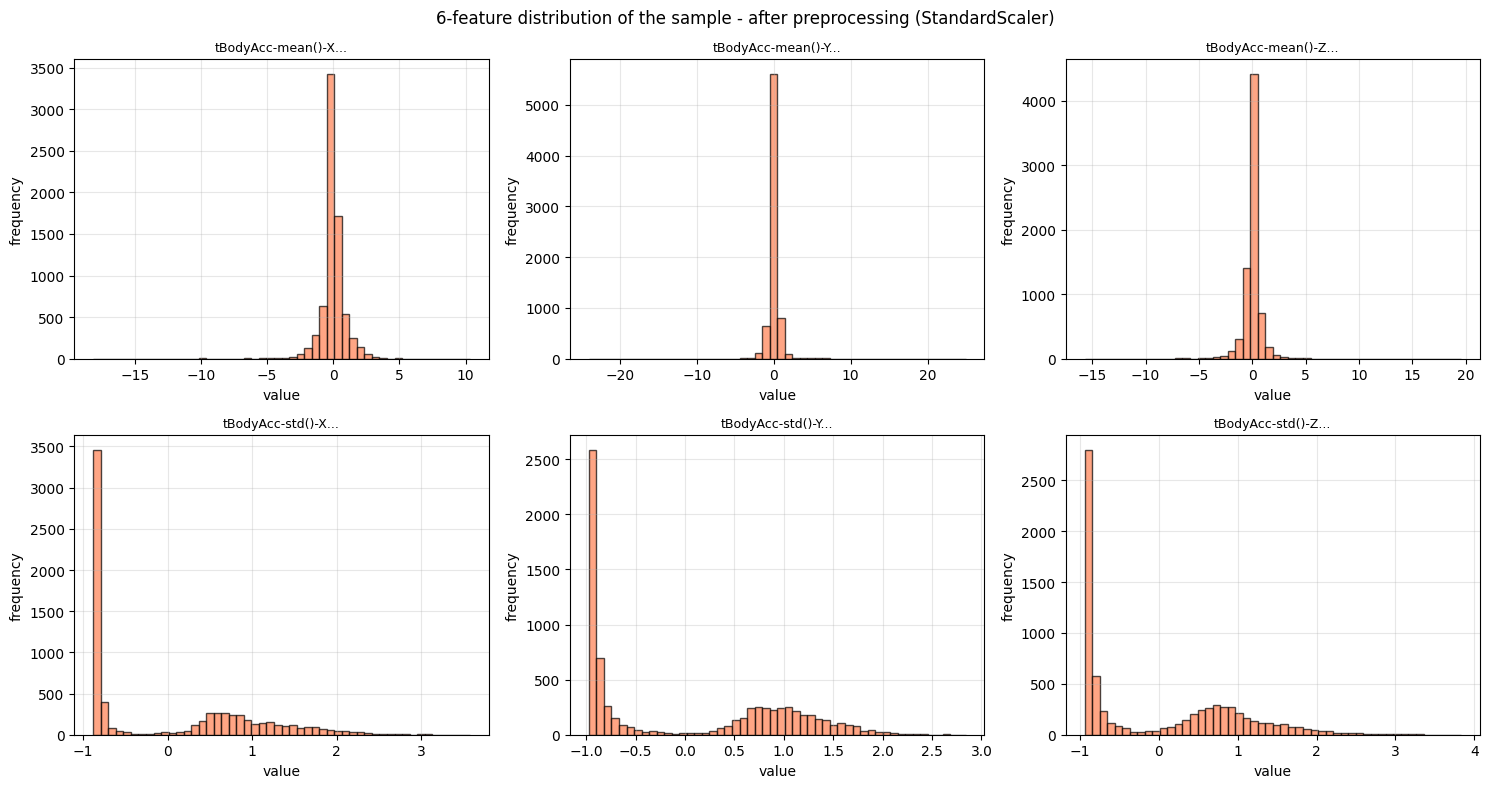

In [12]:
# Show distribution after scaling
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('6-feature distribution of the sample - after preprocessing (StandardScaler)')
for idx, feature in enumerate(sample_features):
    row, col = idx // 3, idx % 3
    axes[row, col].hist(X_train_scaled[feature], bins=50, color='coral', alpha=0.7, edgecolor='black')
    axes[row, col].set_title(f'{feature[:30]}...', fontsize=9)
    axes[row, col].set_xlabel('value')
    axes[row, col].set_ylabel('frequency')
    axes[row, col].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('distribution_after_scaling.pdf',bbox_inches='tight')
plt.show()



## Dimension reduction